# Developping the python Class for joining dataset. 

This includes a basic utils functions for preprocessing of the data and the attribution class.

In [1]:
from typing import List, Dict, Tuple, Set, Optional, Callable
import geopandas as gpd
import dask_geopandas as dgpd
import pandas as pd
import dask.dataframe as dd
import numpy as np


#write a function that verify if the input is a valid GeoDataFrame, meaning that it has a geometry column, a definied crs and a non-empty geometry column, a 'class' column (string) and a valid index column (int) and two datetimes
def is_dataset_valid(name: str, dataset: gpd.GeoDataFrame, ref=False) -> bool:
    assert isinstance(dataset, gpd.GeoDataFrame), f"dataset '{name}' is not a GeoDataFrame"
    assert 'geometry' in dataset.columns, f"dataset '{name}' has no geometry column"
    assert dataset.crs is not None, f"dataset '{name}' has no crs"
    assert dataset.index.dtype == int, f"dataset '{name}' has no valid index column"
    if not ref:
        assert 'class' in dataset.columns, f"dataset '{name}' has no class column"
        dataset['class'] = dataset['class'].astype(str)

    #check if the 'start_date' and 'end_date' columns are present, if not check if a column 'year' is present
    if 'start_date' not in dataset.columns:
        assert 'year' in dataset.columns, f"dataset '{name}' has no start_date or year column"

        #if year in column, create a start_date and end_date column as the first and last day of this year
        dataset['start_date'] = pd.to_datetime(dataset['year'], format='%Y')
        dataset['end_date'] = pd.to_datetime(dataset['year'], format='%Y') + pd.offsets.YearEnd(0)
        


    assert 'start_date' in dataset.columns, f"dataset '{name}' has no start_date column"
    assert 'end_date' in dataset.columns, f"dataset '{name}' has no end_date column"
    dataset['start_date'] = pd.to_datetime(dataset['start_date'], format='%Y-%m-%d')
    dataset['end_date'] = pd.to_datetime(dataset['end_date'], format='%Y-%m-%d')
    dataset['dataset'] = name
    
    return dataset 

def classify_source_type(gdf : gpd.GeoDataFrame, area_threshold = 101) -> str:
    assert gdf.crs == 'epsg:2154', "crs is not epsg:2154"
    """area threshold should be viewed as the granularity level of the attribution"""
    
    areas = gdf.geometry.area / 1e6
    mean = np.mean(areas)
    std = np.std(areas)
    mi = np.min(areas)
    ma = np.max(areas)
    median = np.median(areas)
    p90 = np.percentile(areas, 90) #change to p95 
    # print(f"[in km2] - mean: {mean}, std: {std}, min: {mi}, max: {ma}, median: {median}, p90: {p90}")

    
    if  p90 >= area_threshold:
        alpha = np.sqrt(area_threshold) / np.sqrt((mean + 2 * std) / np.pi) #change to np.sqrt(area_threshold / np.pi)
        print(f'suggested value for alpha : {alpha :.2f}')
        return 'spatial_entity', alpha 
    else:
        alpha = None
        return 'point/polygon', alpha

def get_spatial_join(dataset: gpd.GeoDataFrame, reference: gpd.GeoDataFrame, t: str, spatial_buffer: int) -> gpd.GeoDataFrame:

    if t == 'point':
        return dataset.sjoin_nearest(reference.compute(), max_distance=spatial_buffer, distance_col='sd')
    
    elif t == 'polygon':
        return dataset.sjoin(reference)
    

class Attribution:
    #ddataset is a dict containing the name of the dataset and the GeoDataframe
    #reference is a GeoDataframe containing the reference data
    #doa is a dict containing the overall accuracy of each dataset 
    #dweights is a dict containing the weight function for each factor 

    #write the init method with typing
    def __init__(self, ddataset: Dict[str, gpd.GeoDataFrame], reference: gpd.GeoDataFrame, 
    doa: Dict[str, float], temporal_buffer: int, dsbuffer: Dict[str, int], dtypes: Dict[str, int], granularity: int = 10):
        
        self.mandatory_columns = ['start_date', 'end_date', 'class', 'dataset', 'year']
        self.granularity = granularity
        self.ddataset = ddataset
        self.dtypes_ = {}
        self.dalpha = {}
        for name, dataset in self.ddataset.items():
            self.ddataset[name] = is_dataset_valid(name, dataset)
            t, alpha = classify_source_type(dataset, area_threshold=self.granularity ** 2 + 1) #change to np.pi * self.granularity ** 2  (model -> circle)
            self.dtypes_[name] = t
            self.dalpha[name] = alpha
        t, alpha = classify_source_type(reference, area_threshold=self.granularity ** 2 + 1) #change to np.pi * self.granularity ** 2  (model -> circle)
        self.dtypes_['reference'] = t
        
        self.reference = is_dataset_valid('reference', reference, ref=True) 
        self.optional_columns = self.get_optional_columns()

        
        self.doa = doa
        self.temporal_buffer = temporal_buffer #years
        self.dsbuffer = dsbuffer #km 
        self.dtypes = dtypes

        assert self.ddataset.keys() == self.doa.keys(), "doa keys are not the same as ddataset keys"
        assert self.ddataset.keys() == self.dsbuffer.keys(), "dsbuffer keys are not the same as ddataset keys"
        assert self.ddataset.keys() == self.dtypes.keys(), "dtypes keys are not the same as ddataset keys"
        assert all([self.ddataset[name].crs == self.reference.crs for name in self.ddataset.keys()]), "not all the geodataframe have the same crs"

    def get_optional_columns(self) -> List[str]:
        cols = []
        for dataset in self.ddataset.values():
            cols.extend(dataset.columns.difference(self.mandatory_columns).values.tolist())

        optional_cols = []
        for col in list(set(cols)):
            if col in self.reference.columns and col != 'geometry':
                self.mandatory_columns.append(col)
            elif col != 'geometry':
                optional_cols.append(col)

        return optional_cols

    #write a method that returns the temporal and spatial join
    def get_spatial_joins(self, ddataset_year: Dict[str, dgpd.GeoDataFrame or gpd.GeoDataFrame], reference_year: dgpd.GeoDataFrame) -> gpd.GeoDataFrame:
        
        #SPATIAL JOIN ~ 10s
        dtsj = []
        for (name, dataset) in ddataset_year.items():
            t = self.dtypes[name]
            dtsj.append(get_spatial_join(dataset, reference_year, t, self.dsbuffer[name]))

        concat1 = dd.concat(dtsj, axis=0).compute()

        #CONCATENATION WITH REF ~ 1s
        col = ['geometry'] + [col + '_left' for col in self.mandatory_columns] + [col for col in self.optional_columns] + ['sd']
        all_index_right = concat1['index_right'].unique()
        concat1 = concat1[['index_right']+col]
        rename = {c: c.split('_left')[0] for c in col}
        concat1 = concat1.rename(columns=rename)
        reference_year['index_right'] = reference_year.index

        #order of reference and concat1 is important. If we want to use iloc[0] on the group to retrieve reference row, we have to stick to this order.
        concat2 = dd.concat([reference_year.loc[all_index_right], concat1], axis=0).compute()

        #MERGING ~ 1s 
        merge = pd.merge(concat2, reference_year.compute(), left_on='index_right', right_index=True)
        drop = ['geometry_y','index_right_y', 'index_right_x'] + [col + '_y' for col in self.mandatory_columns] 
        merge = merge.drop(columns=drop)
        rename = {c: c.split('_x')[0] for c in merge.columns} 
        rename.update({'index_right': 'index_reference'})
        return merge.rename(columns=rename).reset_index()


# Loading dataset

In [2]:
import geopandas as gpd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_DFDE_1984_2021_EPSG2154_FR.parquet')
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet')
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet")
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2015_2022_FR_EPSG2154.parquet')
# tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')

In [3]:
#preprocessing bdiff:
bdiff['class'] = 'Fire'

#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

In [4]:
#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

In [5]:
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon'}
doa = {'dfde': 0.95, 'hm': 1.0, 'nfi': 0.75, 'senfseidl': 0.88, 'bdiff': 0.95}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None}
temporal_buffer = 5

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, granularity=10)

suggested value for alpha : 0.06


In [6]:
#Temporal buffer 
import dask_geopandas as dgpd
year = 2019
ddataset_year = {}
for name, dataset in attribution.ddataset.items():
    t = attribution.dtypes[name]
    d = dataset[(dataset['start_date'].dt.year >= year - temporal_buffer) & (dataset['end_date'].dt.year <= year + temporal_buffer)]
    if t == 'point':
        ddataset_year[name] = d
    elif t == 'polygon':
        ddataset_year[name] = dgpd.from_geopandas(d, npartitions=10)

reference_year = attribution.reference[ attribution.reference['year'] == year ]
reference_year = dgpd.from_geopandas(reference_year, npartitions=10)


In [7]:
attribution_year = attribution.get_spatial_joins(ddataset_year, reference_year)


In [8]:
attribution_year.dataset.value_counts()

dataset
bdiff        318832
senfseidl    243846
reference    108851
hm            15885
nfi           11385
dfde           5853
Name: count, dtype: int64[pyarrow]

## Visualisation

In [134]:
groups = attribution_year.groupby('index_reference')

from itertools import islice 

gr = []
for name, group in islice(groups, 0, 1000):
    gr.append(group)

In [135]:
[i for i,r in enumerate(gr) if len(r.dataset.unique()) > 3 ]

[32,
 70,
 117,
 128,
 131,
 177,
 185,
 229,
 246,
 260,
 375,
 389,
 418,
 425,
 577,
 594,
 634,
 698,
 762,
 794,
 805,
 807,
 810,
 820,
 834,
 888,
 924,
 955,
 971,
 978,
 994]

In [129]:
data = gr[222]

try:
    data['start_date'] = data['start_date'].dt.strftime('%Y-%m-%d')
except :
    pass 

try:
    data['end_date'] = data['end_date'].dt.strftime('%Y-%m-%d')
except : 
    pass

data.explore(column = 'dataset', 
             tooltip = ['year', 'start_date', 'end_date', 'essence', 'class', 'notes'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

## Group clasification

Computation of similiarity matrix in the followings spaces : 
- x
- y 
- start-date
- end-date
- tree-specie
- class

In [9]:
groups = attribution_year.groupby('index_reference')

from itertools import islice 

gr = []
for name, group in islice(groups, 0, 10000):
    gr.append(group)

In [87]:
[i for i,r in enumerate(gr) if len(r.dataset.unique()) > 3 ]

[32,
 70,
 117,
 128,
 131,
 177,
 185,
 229,
 246,
 260,
 375,
 389,
 418,
 425,
 577,
 594,
 634,
 698,
 762,
 794,
 805,
 807,
 810,
 820,
 834,
 888,
 924,
 955,
 971,
 978,
 994]

### Weights design

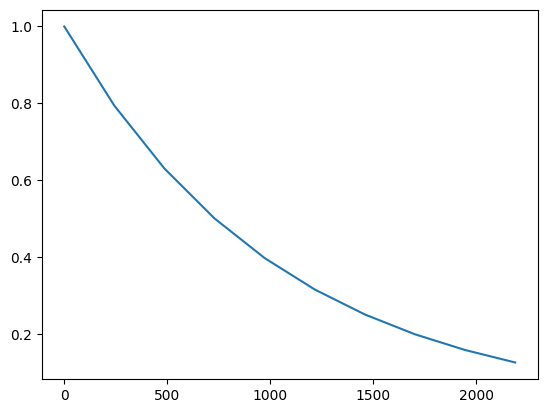

In [194]:
import numpy as np

def exponential_decay(days: int, half_life: int) -> float:
    return np.exp(-np.log(2) * days / half_life)

half_life = 2 * 365
a = np.linspace(0, 6*365, 10)

import matplotlib.pyplot as plt
plt.plot(a, exponential_decay(a, half_life))


### Similarity matrix

In [113]:
#test if one group in gr has a dataset called dfde 
[i for i,r in enumerate(gr) if 'dfde' in r.dataset.unique() ]

[6852,
 6853,
 6854,
 6856,
 6857,
 6858,
 6859,
 6866,
 6869,
 6871,
 6874,
 6881,
 6885,
 6891,
 6894,
 6895,
 6896,
 6902,
 6908,
 6911,
 6912,
 6922,
 6927,
 6932,
 6935,
 6940,
 6945,
 6950,
 6952,
 6953,
 6959,
 6961,
 6962,
 6963,
 6964,
 6966,
 6967,
 6968,
 6974,
 6977,
 6979,
 6984,
 6988,
 6996,
 6998,
 7009,
 7011,
 7014,
 7015,
 7023,
 7025,
 7030,
 7033,
 7034,
 7048,
 7049,
 7050,
 7056,
 7059,
 7064,
 7076,
 7079,
 7086,
 7087,
 7088,
 7089,
 7090,
 7096,
 7097,
 7098,
 7100,
 7113,
 7115,
 7117,
 7121,
 7126,
 7127,
 7128,
 7129,
 7130,
 7145,
 7149,
 7151,
 7154,
 7157,
 7158,
 7163,
 7164,
 7167,
 7169,
 7170,
 7175,
 7184,
 7186,
 7188,
 7189,
 7191,
 7196,
 7200,
 7201,
 7204,
 7205,
 7206,
 7207,
 7209,
 7210,
 7212,
 7213,
 7214,
 7221,
 7236,
 7242,
 7253,
 7254,
 7258,
 7262,
 7271,
 7272,
 7280,
 7295,
 7301,
 7306,
 7307,
 7309,
 7312,
 7314,
 7318,
 7319,
 7321,
 7327,
 7330,
 7332,
 7336,
 7338,
 7339,
 7340,
 7343,
 7344,
 7345,
 7349,
 7350,
 7351,
 7357,

In [118]:
data = gr[7015]
data 

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,name,area,cause,forest_area_m2,notes,sd
4795,1529967,1529967,"POLYGON ((1003774.558 6890412.231, 1003776.021...",2019.0,Mixed,mixed,<NA>,2019-01-01,2019-12-31,reference,<NA>,NaN,<NA>,NaN,<NA>,NaN
4796,63,1529967,"POLYGON ((1016482.342 6707283.553, 996492.098 ...",NaN,mixed,conifers;broadleaves,Biotic,2014-01-01,2014-12-28,dfde,<NA>,1.107470e+10,Biotic;Abiotic,NaN,state forests (only barked wood for the Alsace...,NaN
4797,64,1529967,"POLYGON ((1016482.342 6707283.553, 996492.098 ...",NaN,mixed,conifers;broadleaves,Biotic,2015-01-01,2015-12-28,dfde,<NA>,1.107470e+10,Biotic;Abiotic,NaN,state forests (only barked wood for the Alsace...,NaN


In [16]:

def calculate_iou(poly1, poly2):
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return intersection / union if union != 0 else 0

def calculate_d_star(area, alpha=1):
    return alpha * np.sqrt(area / np.pi)

def build_spatial_matrix(gdf: gpd.GeoDataFrame, dtypes_: Dict[str, str], dalpha: Dict[str, float], w: Callable) -> np.ndarray:
    num_elements = len(gdf)
    distance_matrix = np.zeros((num_elements, num_elements))

    if not any([dtypes_[name] == 'spatial_entity' for name in data.dataset.unique()]):
        # Calculate distances only for the upper triangle of the matrix
        for i in range(num_elements):
            for j in range(i + 1, num_elements):  # Start from i+1 to skip the diagonal
                # Calculate distance between points
                distance = gdf.geometry.iloc[i].centroid.distance(gdf.geometry.iloc[j].centroid)
                # Convert distance to similarity
                similarity = w(distance)
                distance_matrix[i][j] = similarity
                distance_matrix[j][i] = similarity  # Mirror the value

    else :
        # Calculate distances only for the upper triangle of the matrix
        for i in range(num_elements):
            for j in range(i + 1, num_elements):  # Start from i+1 to skip the diagonal
                d_i = gdf.iloc[i]['dataset']
                d_j = gdf.iloc[j]['dataset']
                t_i = dtypes_[d_i]
                t_j = dtypes_[d_j]

                if t_i == 'point/polygon' and t_j == 'point/polygon':
                    distance = gdf.geometry.iloc[i].centroid.distance(gdf.geometry.iloc[j].centroid)
                elif t_i == 'spatial_entity' and t_j == 'spatial_entity':
                    area_i = gdf.geometry.iloc[i].area
                    area_j = gdf.geometry.iloc[j].area
                    d_star_i = calculate_d_star(area_i, dalpha[d_i])
                    d_star_j = calculate_d_star(area_j, dalpha[d_j])
                    iou = calculate_iou(gdf.geometry.iloc[i], gdf.geometry.iloc[j])
                    distance = (d_star_i + d_star_j) / 2 / iou if iou > 0 else (d_star_i + d_star_j) / 2
                else:
                    if t_i == 'spatial_entity':
                        area_i = gdf.geometry.iloc[i].area
                        distance = calculate_d_star(area_i, dalpha[d_i])
                    else:
                        area_j = gdf.geometry.iloc[j].area
                        distance = calculate_d_star(area_j, dalpha[d_j])

                similarity = w(distance) ##
                distance_matrix[i][j] = similarity
                distance_matrix[j][i] = similarity

        # Fill the diagonal with the maximum similarity score, e.g., 1
    np.fill_diagonal(distance_matrix, 1)
    return distance_matrix

In [20]:
#spatial weights
def spatial_weight(x) -> float:
    if x <= 500:
        return 1
    else: 
        return 1 - (x-500)/9500
    
v_spatial_weight = np.vectorize(spatial_weight, otypes=['float'])

#temporal weights
def temporal_weight(x) -> float:
    x = x/365 
    if x <= 3:
        return 1 - x/12
    else: 
        return 0.75 * (1 - (x-3)/3)
    
vectorized_temporal_weight = np.vectorize(temporal_weight, otypes=['float'])

#import fuzz
from thefuzz import fuzz 
def compute_tree_coherence(row1, row2) -> float:

    for essence1 in row1['essence'].split(','):
        for essence2 in row2['essence'].split(','):
            if fuzz.token_set_ratio(essence1.lower(), essence2.lower()) > 80:
                return 1
        
    if row1['tree_type'].lower() == row2['tree_type'].lower():
        return 0.75 
    
    if row1['tree_type'].lower() == 'mixed' or row2['tree_type'].lower() == 'mixed':
        return 0.5

    return 0.25 

def category_based_similarity(row1, row2, dclass):

    class1 = row1['class']
    class2 = row2['class']
    dataset1 = row1['dataset']
    dataset2 = row2['dataset']
    lclass1 = dclass[dataset1][class1]
    lclass2 = dclass[dataset2][class2]
    
    for c1 in lclass1:
        for c2 in lclass2:
            if c1 == c2:
                return 1
    if ('biotic' in ' '.join(lclass1) and 'biotic' in ' '.join(lclass2)) or \
          ('dieback' in ' '.join(lclass1) and 'dieback' in ' '.join(lclass2)) :
        return 0.75
    if (('storm' in ' '.join(lclass1) or 'biotic' in ' '.join(lclass1)) and \
             ('storm' in ' '.join(lclass2) or 'biotic' in ' '.join(lclass2))):
        return 0.5
    else :
        return 0.25
    
# Function to build the similarity matrix
def build_custom_matrix(df : pd.DataFrame, custom_similarity_function : Callable, kwargs: dict) -> np.ndarray:
    n = len(df)
    # Initialize the similarity matrix with zeros
    similarity_matrix = np.zeros((n, n))
    
    # Iterate over each pair of rows
    for i in range(n):
        for j in range(i+1, n):  # Use range(i, n) to avoid redundant computations
            # Compute the tree coherence for each pair of rows
            similarity = custom_similarity_function(df.iloc[i], df.iloc[j], **kwargs)
            # Fill in the matrix, it's symmetric so we can do both i,j and j,i
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    np.fill_diagonal(similarity_matrix, 1)

    return similarity_matrix


import numpy as np
dclass ={
    'senfseidl': {
        'Storm,Biotic': ['biotic-mortality', 'storm'],
        'Fire' : ['fire'],
        'Other' : ['biotic-dieback', 'drought-dieback', 'antropogenic']
    },
    'dfde': {
        'Biotic':['biotic-mortality', 'biotic-dieback'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought':['drought-dieback'],
        'Other':['antropogenic']
    },
    'nfi': {
        'Biotic-dieback':['biotic-dieback'],
        'Biotic-mortality':['biotic-mortality'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought':['drought-dieback'],
        'Other':['antropogenic'],
        'Tree-logging':['antropogenic']
    },
    'hm': {
        'Biotic':['biotic-mortality', 'biotic-dieback'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought-dieback':['drought-dieback'],
        'Other':['antropogenic']
    },
    'bdiff': {
        'Fire':['fire']
    },
    'reference': {
        'None':['biotic-mortality', 'biotic-dieback', 'storm', 'fire', 'drought-dieback', 'antropogenic'],
        None:['biotic-mortality', 'biotic-dieback', 'storm', 'fire', 'drought-dieback', 'antropogenic']
    }
}

def build_temporal_matrix(data, w= lambda x:x):

    #temporal
    start_date_matrix = data['start_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix_sd = np.abs((start_date_matrix - start_date_matrix.T) / np.timedelta64(1, 'D'))
  
    end_date_matrix = data['end_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix_ed = np.abs((end_date_matrix - end_date_matrix.T) / np.timedelta64(1, 'D'))

    return  w(((day_diff_matrix_sd) + (day_diff_matrix_ed))/2)


def compute_similarity_matrix(data : gpd.GeoDataFrame, dtypes_: Dict[str, str], dalpha: Dict[str, float], dcustom_similarity_function : Dict[str, Tuple[Callable, dict, float]]) \
    -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """Compute all the different similarity matrices and combine them into a single matrix

    Args:
        data (gpd.GeoDataFrame): GeoDataFrame containing the data to be compared
        dcustom_similarity_function (Dict[str, Tuple[Callable, dict, float]]): Dictionary containing the custom similarity functions, the optional arguments and the weight associated with each function

    Returns:
        Tuple[np.ndarray, Dict[str, np.ndarray]] : the combined single similarity matrix and the dictionary containing all the similarity matrices
    """
    weights = {'spatial': 1.0, 'temporal':1.0}
    weights.update({name: w for name, (custom_function, args, w) in dcustom_similarity_function.items()})

    #MANDATORY SIMILARITY FACTORS
    
    #spatial 
    data = data.fillna('None')
    matrices = {}
    matrices['spatial'] = np.nan_to_num(build_spatial_matrix(data, dtypes_=dtypes_, dalpha=dalpha, w=spatial_weight), nan=0).clip(0,1)

    #temporal
    matrices['temporal'] = np.nan_to_num(build_temporal_matrix(data, w=vectorized_temporal_weight), nan=0).clip(0,1)

    #CUSTOM  SIMILARITY FACTORS
    for name, (custom_function, kwargs, _) in dcustom_similarity_function.items():
        matrices[name] = np.nan_to_num(build_custom_matrix(data, custom_function, kwargs), nan=0).clip(0,1)

    return np.average(np.array(list(matrices.values())), axis=0, weights=list(weights.values())), matrices

from sklearn.cluster import SpectralClustering

from collections import defaultdict


def get_predominant_class(l):
    if len(l) == 1:
        return l[0][0]
    elif len(np.unique([l[0] for l in l])) > 1:
        # Step 1: Group by class and calculate sum of similarities and count
        class_stats = defaultdict(lambda: {'count': 0, 'similarity_sum': 0.0})
        for entry in l:
            class_name, similarity = entry
            class_stats[class_name]['count'] += 1
            class_stats[class_name]['similarity_sum'] += similarity

        # Step 2: Calculate average similarity for each class
        for class_name, stats in class_stats.items():
            stats['average_similarity'] = stats['similarity_sum'] / stats['count']

        # Step 3: Determine the class with the highest frequency
        # Step 4: If there's a tie, use average similarity
        sorted_classes = sorted(class_stats.items(), key=lambda item: (-item[1]['count'], -item[1]['average_similarity']))
        return sorted_classes[0][0]
    else :
        return 'multi-factor'

def get_cluster(data : gpd.GeoDataFrame, dcustom_similarity_function : Dict[str, Tuple[Callable, dict, float]], dtypes_: Dict[str, str], dalpha: Dict[str, float], threshold=0.5) -> gpd.GeoDataFrame :

    similarity_matrix, _ = compute_similarity_matrix(data, dtypes_=dtypes_, dalpha=dalpha, dcustom_similarity_function=dcustom_similarity_function)

    #compute clusters 
    c = []
    for i in range(1, len(data)):
        c.extend(dclass[data.iloc[i]['dataset']][data.iloc[i]['class']])

    l, c = np.unique(c, return_counts=True)

    n_clusters = max(1,len(data.iloc[1:]['class'].unique()) - len([x for x in c if x > 1])) #number of unique classes - number of classes that are present in more than one dataset
    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = sc.fit_predict(similarity_matrix)
    data['labels'] = labels

    # Unique cluster labels
    cluster_labels = data['labels'].iloc[1:]
    unique_labels = np.unique(cluster_labels)

    # Dictionary to hold the sum of scores and the count for each cluster
    cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

    # Sum scores and counts for each cluster
    for i, (score, label) in enumerate(zip(similarity_matrix[0][1:], cluster_labels)):
        ws = score * doa[data['dataset'].iloc[i+1]]
        cluster_sums[label]['sum'] += ws 
        cluster_sums[label]['count'] += 1
        cluster_sums[label]['class'].extend([(x,ws) for x in dclass[data['dataset'].iloc[i+1]][data['class'].iloc[i+1]]])

    # Compute average score for each cluster
    average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}
    timeperiod_group = {}
    data_ = data.iloc[1:].copy()
    data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
    data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

    #get date of the median start and end date for each cluster
    for group in data_['labels'].unique():
        group_df = data_[data_['labels'] == group]
        median_start = group_df['start_date'].median()
        median_end = group_df['end_date'].median()
        timeperiod_group[group] = (median_start, median_end)

    for label in average_scores:
        average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label])

    # Filter the dictionary based on similarity score > 0.5
    filtered_d = {k: v for k, v in average_scores.items() if v[0] > threshold}

    # Convert the filtered dictionary into a DataFrame
    df = pd.DataFrame.from_dict(filtered_d, orient='index', columns=['Similarity', 'Class', 'TimePeriod'])

    # Ensure the dates are in the correct format (if they are strings)
    df['Start_Date'], df['End_Date'] = zip(*df['TimePeriod'])
    df = df.drop('TimePeriod', axis=1)

    # Convert the string dates to datetime objects if needed
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
    df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

    # df[['geometry', 'detection_year','tree_type', 'essence', 'index_reference']] = data.iloc[0][['geometry', 'year','tree_type', 'essence', 'index_reference']]
    df['index_reference'] = data.iloc[0]['index_reference']
    return df.sort_values(by='Similarity', ascending=False)


In [13]:
attribution_year.columns

Index(['index', 'index_reference', 'geometry', 'year', 'tree_type', 'essence',
       'class', 'start_date', 'end_date', 'dataset', 'area', 'notes', 'cause',
       'forest_area_m2', 'name', 'sd'],
      dtype='object')

In [22]:
import dask.dataframe as dd

cols = ['index', 'index_reference', 'geometry', 'year', 'tree_type', 'essence',
       'class', 'start_date', 'end_date', 'dataset']

dataset_test = dd.from_pandas(attribution_year[cols], npartitions=10)
dtypes = {
    'Similarity': 'float',
    'Class': 'string',
    'Start_Date': 'datetime64[ns]',
    'End_Date': 'datetime64[ns]',
    'index_reference': 'int'
}
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (category_based_similarity, {'dclass': dclass}, 1.0)}

meta = pd.DataFrame(columns=dtypes.keys()).astype(dtypes)
r = dataset_test.map_partitions(lambda df: df.groupby('index_reference',as_index=True).apply(get_cluster, dtypes_=attribution.dtypes_, dalpha=attribution.dalpha, dcustom_similarity_function=dcustom_similarity_function, threshold=0.), meta=meta).compute()

ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required by SpectralClustering.

In [21]:
#remove warning 
# 1000 -> 38s
# 100000 -> 1h 03min
import warnings
warnings.filterwarnings('ignore')
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (category_based_similarity, {'dclass': dclass}, 1.0)}
from tqdm import tqdm
for i in tqdm(range(1000)):
    data = gr[i]
    # similarity_matrix, matrices = compute_similarity_matrix(data)
    df = get_cluster(data, dtypes_=attribution.dtypes_, dalpha=attribution.dalpha, dcustom_similarity_function=dcustom_similarity_function, threshold=0.)

100%|██████████| 1000/1000 [00:44<00:00, 22.37it/s]


In [191]:
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (category_based_similarity, {'dclass': dclass}, 1.0)}
get_cluster(gr[4739],  dcustom_similarity_function=dcustom_similarity_function,threshold=0.)

,Similarity,Class,Start_Date,End_Date,index_reference
0,0.861667,biotic-dieback,2018-01-01,2018-12-31,1444888


/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_868/2499311600.py:171: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  data = data.fillna('None')


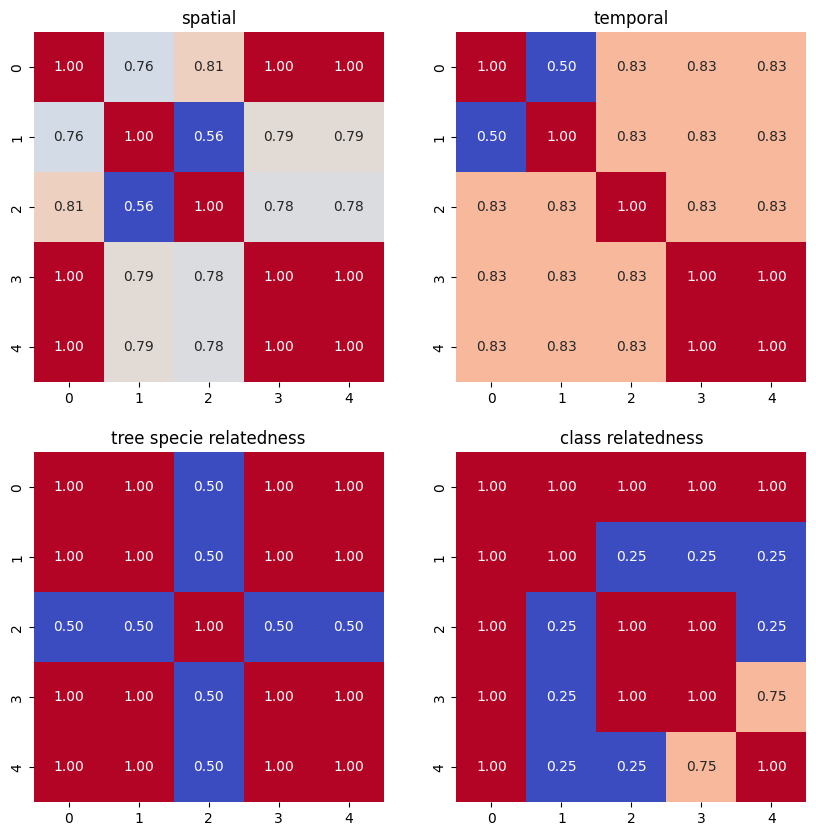

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

data = gr[762]
similarity_matrix, matrices = similarity_matrix, matrices = compute_similarity_matrix(data, {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (category_based_similarity, {'dclass': dclass}, 1.0)})
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes_ = [ (0,0), (0,1), (1,0), (1,1) ]

for ax, (name, matrices) in zip(axes_, matrices.items()):
    axes[ax].set_title(name)
    sns.heatmap(matrices, annot=True, cmap='coolwarm', square=True, ax=axes[ax], cbar=False, fmt='.2f')




<Axes: >

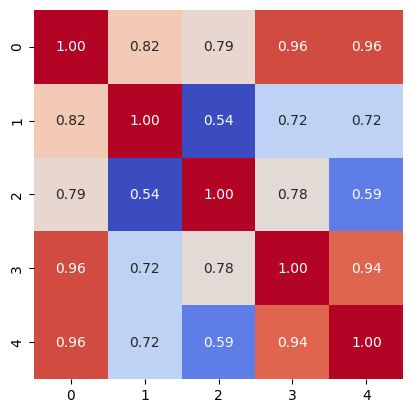

In [169]:
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, cbar=False, fmt='.2f')

In [166]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,name,area,cause,forest_area_m2,notes,sd
15501,1083786,1083786,"POLYGON ((760825.789 6990451.896, 760826.386 6...",2019.0,Mixed,"mixed,fir, spruce",<NA>,2019-01-01 00:00:00,2019-12-31,reference,<NA>,NaN,<NA>,NaN,<NA>,NaN
15502,4497,1083786,"POLYGON ((752770.586 6989630.657, 752787.739 6...",2015.0,Mixed,"broadleaf,poplar,mixed,fir, spruce,deciduous o...",Fire,2015-01-01 00:00:00,2015-12-31,bdiff,"Le Nouvion-en-Thiérache, Vervins, Aisne, Hauts...",NaN,<NA>,1000.0,<NA>,NaN
15503,81997,1083786,POINT (762529.545 6988939.727),NaN,Broadleaf,Pedunculate Oak,Tree-logging,2014-12-27 18:00:00,2019-12-28,nfi,<NA>,NaN,<NA>,NaN,<NA>,2241.017324
15504,1648792,1083786,"POLYGON ((760499.585 6990846.048, 760559.404 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce",Other,2017-01-01 00:00:00,2017-12-31,senfseidl,<NA>,NaN,<NA>,NaN,<NA>,0.000000
15505,1721996,1083786,"POLYGON ((760436.961 6990870.256, 760496.779 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce","Storm,Biotic",2017-01-01 00:00:00,2017-12-31,senfseidl,<NA>,NaN,<NA>,NaN,<NA>,0.000000


<Axes: >

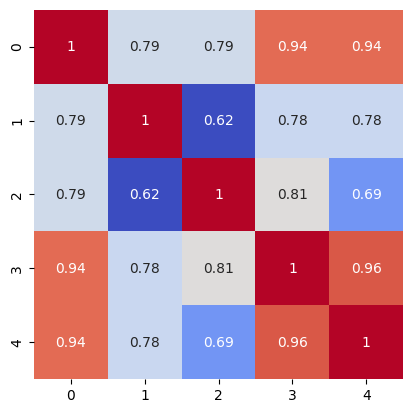

In [314]:
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, cbar=False)

In [315]:
from sklearn.cluster import SpectralClustering

c = []
for i in range(1, len(data)):
    c.extend(dclass[data.iloc[i]['dataset']][data.iloc[i]['class']])

l, c = np.unique(c, return_counts=True)

n_clusters = len(data.iloc[1:]['class'].unique()) - len([x for x in c if x > 1]) #number of unique classes - number of classes that are present in more than one dataset
# Perform spectral clustering
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
labels = sc.fit_predict(similarity_matrix)


In [323]:


data['labels'] = labels

# Unique cluster labels
cluster_labels = data['labels'].iloc[1:]
unique_labels = np.unique(cluster_labels)

# Dictionary to hold the sum of scores and the count for each cluster
cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

# Sum scores and counts for each cluster
for i, (score, label) in enumerate(zip(similarity_matrix[0][1:], cluster_labels)):
    ws = score * doa[data['dataset'].iloc[i+1]]
    cluster_sums[label]['sum'] += ws 
    cluster_sums[label]['count'] += 1
    cluster_sums[label]['class'].extend([(x,ws) for x in dclass[data['dataset'].iloc[i+1]][data['class'].iloc[i+1]]])

# Compute average score for each cluster
average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}
timeperiod_group = {}
data_ = data.iloc[1:].copy()
data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

for group in data_['labels'].unique():
    group_df = data_[data_['labels'] == group]
    median_start = group_df['start_date'].median()
    median_end = group_df['end_date'].median()
    timeperiod_group[group] = (median_start, median_end)

for label in average_scores:
    average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label])

average_scores


{0: (0.5954810364197152,
  'antropogenic',
  (Timestamp('2014-12-27 00:00:00'), Timestamp('2019-12-28 00:00:00'))),
 1: (0.8311111111111112,
  'biotic-dieback',
  (Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))),
 2: (0.7540825004295159,
  'fire',
  (Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00')))}

In [317]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,name,area,cause,notes,forest_area_m2,sd,labels
15501,1083786,1083786,"POLYGON ((760825.789 6990451.896, 760826.386 6...",2019.0,Mixed,"mixed,fir, spruce",<NA>,2019-01-01,2019-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,NaN,1
15502,4497,1083786,"POLYGON ((752770.586 6989630.657, 752787.739 6...",2015.0,Mixed,"broadleaf,poplar,mixed,fir, spruce,deciduous o...",Fire,2015-01-01,2015-12-31,bdiff,"Le Nouvion-en-Thiérache, Vervins, Aisne, Hauts...",NaN,<NA>,<NA>,1000.0,NaN,2
15503,81997,1083786,POINT (762529.545 6988939.727),NaN,Broadleaf,Pedunculate Oak,Tree-logging,2014-12-27,2019-12-28,nfi,<NA>,NaN,<NA>,<NA>,NaN,2241.017324,0
15504,1648792,1083786,"POLYGON ((760499.585 6990846.048, 760559.404 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce",Other,2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
15505,1721996,1083786,"POLYGON ((760436.961 6990870.256, 760496.779 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce","Storm,Biotic",2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1


In [310]:
try:
    data['start_date'] = data['start_date'].dt.strftime('%Y-%m-%d')
except :
    pass 

try:
    data['end_date'] = data['end_date'].dt.strftime('%Y-%m-%d')
except : 
    pass

data.explore(column = 'dataset', 
             tooltip = ['year', 'start_date', 'end_date', 'essence', 'class', 'notes', 'labels'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

# Others

In [155]:
import numpy as np
def compute_weight_on_merge(row, row_ref, dtypes, doa):
    # spatial distance, spatial weight, temporal distance, temporal weight, tree correspondance weight, overall accuracy
    
    if row['dataset'] == 'reference':
        return 0, 1, 0, 1, 1, 0, 0 
    elif dtypes[row['dataset']] == 'polygon':
        sd = (row['area'] / 1e6)** (1/2) / 35

    elif dtypes[row['dataset']] == 'point':
        sd = row['sd'] / 1e3

    oa = doa[row['dataset']]
    td = min(abs(row_ref['year'] - row['start_date'].year), abs(row['end_date'].year - row_ref['year']))
   
    tc = compute_tree_coherence(row['tree_type'], row['essence'], row_ref['tree_type'], row_ref['essence'])
    sw = spatial_weight(sd)
    tw = temporal_weight(td)

    return sd, sw, td, tw, tc, oa, np.mean([sw,tw,tc]) * oa

In [156]:
data = gr[32]
data[['sd', 'sw', 'td', 'tw', 'tc', 'oa', 'gw']] = data.apply(compute_weight_on_merge, axis=1, result_type='expand', args=(data.iloc[0], attribution.dtypes, attribution.doa))

In [157]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,...,cause,notes,forest_area_m2,sd,sw,td,tw,tc,oa,gw
13577,566615,566615,"POLYGON ((622612.775 7079137.226, 622612.388 7...",2019.0,Broadleaf,"beech,broadleaf",<NA>,2019-01-01 00:00:00,2019-12-31,reference,...,<NA>,<NA>,NaN,0.000000,1.000000,0.0,1.000000,1.00,0.00,0.000000
13578,43374,566615,"POLYGON ((622635.601 7079076.133, 622665.548 7...",2018.0,Broadleaf,broadleaf,Other,2018-01-01 00:00:00,2018-12-31,senfseidl,...,<NA>,<NA>,NaN,0.040535,1.000000,1.0,0.916667,1.00,0.88,0.855556
13579,43375,566615,"POLYGON ((622632.717 7079106.023, 622635.601 7...",2018.0,Broadleaf,"beech,broadleaf",Other,2018-01-01 00:00:00,2018-12-31,senfseidl,...,<NA>,<NA>,NaN,0.000000,1.000000,1.0,0.916667,1.00,0.88,0.855556
13580,59372,566615,POINT (623634.425 7078759.309),2020.0,broadleaf,Maples,Biotic,2020-01-01 00:00:00,2020-12-31,hm,...,Maladie de la suie,"5 sujets bois moyen ont été observés, mort.",NaN,1.080323,0.991075,1.0,0.916667,0.75,1.00,0.885914
13581,66485,566615,POINT (623345.381 7078072.360),NaN,Broadleaf,Pedunculate Oak,Biotic-mortality,2016-12-27 18:00:00,2021-12-28,nfi,...,<NA>,<NA>,NaN,1.258140,0.971318,2.0,0.833333,0.75,0.75,0.638663
13582,92547,566615,POINT (622362.610 7080079.704),NaN,Broadleaf,Pedunculate Oak,Biotic-mortality,2016-12-27 18:00:00,2021-12-28,nfi,...,<NA>,<NA>,NaN,0.966180,1.000000,2.0,0.833333,0.75,0.75,0.645833
13583,2014857,566615,"POLYGON ((622632.717 7079106.023, 622662.664 7...",2019.0,Broadleaf,broadleaf,Other,2019-01-01 00:00:00,2019-12-31,senfseidl,...,<NA>,<NA>,NaN,0.020602,1.000000,0.0,1.000000,1.00,0.88,0.880000
13584,2014858,566615,"POLYGON ((622659.780 7079138.817, 622689.727 7...",2019.0,Broadleaf,broadleaf,Other,2019-01-01 00:00:00,2019-12-31,senfseidl,...,<NA>,<NA>,NaN,0.047033,1.000000,0.0,1.000000,1.00,0.88,0.880000
